In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [2]:
import tqdm 

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

import lal
import lalsimulation as lalsim

from scrinet.interfaces import lalutils

In [4]:
from scrinet.greedy import greedyrb
from scrinet.surrogate import surrogate
from scrinet.fits import poly

In [168]:
import sys
sys.path.append("../../rom")
import gprfit

# data generation

In [5]:
def gen_1d_massratio_data(q_array, M, deltaT=1/1024., f_min=10,
                         approximant=lalsim.SEOBNRv4_opt, inclination=0,
                          t_min=-10000, t_max=100, npts=5000
                         ):

    new_times = np.linspace(t_min, t_max, npts)
    
    data = []
    coords = []
    
    for q in q_array:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaT=deltaT,
                  f_min=f_min,
                  inclination=inclination,
                  approximant=approximant
                 )
        p = lalutils.gen_td_wf_params(**pp)
        t, amp, phase = lalutils.gen_td_wf(p, t_min=t_min, t_max=t_max)
              
        iamp = IUS(t, amp)
        iphase = IUS(t, phase)
        
        amp = iamp(new_times)
        phase = iphase(new_times)
        
        
#         tshift = lalutils.peak_align_shift(new_times, amp, npts=100000)
#         amp = lalutils.peak_align_interp(new_times, amp, tshift)
#         phase = lalutils.peak_align_interp(new_times, phase, tshift)
        
        d = {"t":new_times, "amp":amp, "phase":phase}
        
        data.append(d)
        coords.append([q])
    
    n_t_points = len(new_times)
    n_waveforms = len(data)
    ts_amp = np.zeros(shape=(n_waveforms, n_t_points))
    ts_phase = np.zeros(shape=(n_waveforms, n_t_points))
    
    
    
    for i in range(n_waveforms):
        ts_amp[i] = data[i]['amp'] / phenom.eta_from_q(coords[i][0]) / 1e5
        ts_phase[i] = data[i]['phase'] - data[i]['phase'][0]
        
    return new_times, ts_amp, ts_phase, np.array(coords)

# surrogate class

In [266]:
import george
from george import kernels

class NewSurrogate(object):
    def __init__(self, integration):
        self.integration = integration

        self.grb = greedyrb.GreedyReducedBasis(
            integration=self.integration
        )

        pass

    def build_seed_basis(self, ts, ts_coords):
        print("building seed basis")
        self.grb.build_seed_basis(ts=ts, ts_coords=ts_coords)

    def run_greedy_sweep(self, ts, ts_coords, greedy_tol=1e-4, verbose=False):
        self.grb.greedy_sweep(ts, ts_coords, greedy_tol=greedy_tol)

    def build_eim(self, ts):
        self.grb.build_eim(ts)

    def fit_eim(self, X, y, maxdegs, max_deg_total, method='lr', verbose=True):
        """
        X: domain. shape = (N, M): N = number of greedy points, M = dimensionality.
            e.g., if non-spinning then M=1
        y: range. shape = (N, N)
            EIM data
        method: default = 'lr' == linear polynomial basis regression
        """
        self.method = method
        
        
        if X.shape[1] > 1 and method == 'gpr':
            raise NotImplementedError(f"Dimension is: {X.shape[0]}. GPR only implemented for 1D at the moment.")
        

        fits = []

        for i, eim_y in enumerate(y):

            if self.method == 'lr':
                max_degs = poly.generate_degrees(
                    maxdegs=maxdegs, max_deg_total=max_deg_total)
                fit, _ = poly.findpolyfit(
                    X,
                    eim_y,
                    max_degs=max_degs,
                    output_best=True,
                    verbose=False
                    )
                fits.append(fit)
            elif self.method == 'gpr':
#                 solver in [george.HODLRSolver, george.BasicSolver]
                solver = george.BasicSolver
                jitter = 1e-4
                yerr = np.zeros(eim_y.shape) + jitter
                fit = gprfit.GPRFit(X, eim_y, yerr=yerr)
                kernel = np.var(eim_y) * kernels.ExpSquaredKernel(0.5, ndim=1, axes=0)
                fit.setup_kernel(kernel)

                fit.fit(solver=solver)
                fit.opt()
                fits.append(fit)

            if verbose:
                import matplotlib
                import matplotlib.pyplot as plt
                
                if self.method == 'lr':
                    yhat = fit.predict(X)
                elif self.method == 'gpr':
                    # haven't implemented uncertainty
                    yhat, _ = fit.predict(X)                
                
                if X.shape[1] == 1:
                    xhat = np.linspace(
                        X.min(),
                        X.max(),
                        1000)
                    if self.method == 'lr':
                        yhat_cont  = fit.predict(xhat.reshape(-1,1))
                    elif self.method == 'gpr':
                        # haven't implemented uncertainty
                        yhat_cont, _  = fit.predict(xhat.reshape(-1,1))
                    plt.figure()
                    plt.title(f"eim data [{i}]")
                    plt.plot(np.exp(xhat), yhat_cont, label='extrap')
                    plt.scatter(np.exp(X.ravel()), eim_y, label='data', s=50, c='r', lw=2)
                    plt.scatter(np.exp(X.ravel()), yhat, label='fit', marker='x', s=100, lw=2, c='k')
                    plt.legend()
                    plt.show()
                    plt.close()
                else:
                    plt.figure()
                    plt.title(f"eim data [{i}]")
                    range_xcont = range(len(yhat_cont))
                    range_x = range(len(yhat))
                    plt.scatter(range_x, eim_y, label='data', s=50, c='r', lw=2)
                    plt.scatter(range_x, yhat, label='fit', marker='x', s=100, lw=2, c='k')
                    plt.legend()
                    plt.show()
                    plt.close()

        self.fits = fits

    def predict(self, coords, log_index=0):
        """
        coords.shape = (1, M), M=dimension
        log_index: take the log of the log_index'th component
        """
        coords = np.array(coords)
        
        assert len(coords.shape) > 1, f"expected shape is (1, M) but got {coords.shape}"
        
        coords[0,log_index] = np.log(coords[0,log_index])

        alpha = np.zeros(len(self.fits))

        if self.method == 'lr':
            for i, fit in enumerate(self.fits):
                alpha[i] = fit.predict(coords)
        elif self.method == 'gpr':
            for i, fit in enumerate(self.fits):
                # haven't implemented uncertainty
                alpha[i], _ = fit.predict(coords)

        return np.dot(alpha, self.grb.eim.B)

    def validate_surrogate(self, vts, vts_coords):
        """
        vts: validation training set
        vts_coords: validation training set coordinates / parameters
        """
        model_errors = np.zeros(len(vts))
        for i in range(len(vts)):
#             q = vts_coords[i]
            yhat = self.predict([vts_coords[i]])
            y = vts[i]
            error = self.grb.integration.norm(y-yhat)**2
            model_errors[i] = error

        worst_error_index = np.argmax(model_errors)
        worst_case = vts_coords[worst_error_index]

        return model_errors, worst_case, worst_error_index

In [267]:
def build_surrogate_iterative(
    amp_or_phase,
    qmin=1,
    qmax=10,
    qnpts=10,
    mtotal=100,
    nvalidation_points=100,
    iterate_surrogate_error=True,
    max_iter=5,
    sur_model_error_tol=2,
    initial_greedy_tol=1e-3,
    iterated_greedy_tol=1e-12,
    fit_method='lr'
):
    """
    qnpts: initial number of points to check seed basis
    nvalidation_points: number of points to validate the model
    
    
    iterate_surrogate_error=True
        if True then will iterate using surrogate error in a second greedy step
        if False then will set max_iter to 1 so that it doesn't iterate
    max_iter:
        max_iter for surrogate iteration greedy step
    sur_model_error_tol:
        error tolerance for 2nd greedy step
    """
    seed_x, seed_ts_amp, seed_ts_phase, seed_ts_coords = gen_1d_massratio_data(np.linspace(qmin, qmax, 3), mtotal)
    # Make integration rule

    int_range = [seed_x[0], seed_x[-1]]
    int_num = len(seed_x)

    integration = greedyrb.Riemann(int_range, num=int_num)
    x = integration.nodes  # Define x for convenience
    
#     sur = surrogate.Surrogate1D(integration)
    sur = NewSurrogate(integration)
    
    if amp_or_phase == "amp":
        seed_ts = seed_ts_amp
    elif amp_or_phase == "phase":
        seed_ts = seed_ts_phase
        
    sur.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)
    
    # check seed basis and add points
    _, ts_amp, ts_phase, ts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, qnpts), mtotal)
    
    if amp_or_phase == "amp":
        ts = ts_amp
    elif amp_or_phase == "phase":
        ts = ts_phase
    
    if iterate_surrogate_error == False:
        # don't iterate
        max_iter = 1
    else:
        print("iterating over surrogate error")
        
    for i in range(max_iter):
        print(f"iteration = {i}")

        if i == 0:
            greedy_tol = initial_greedy_tol
            
        else:
            greedy_tol = iterated_greedy_tol
            ts = vts_worst.reshape(1,-1)
            ts_coords = vts_coords_worst.reshape(1,-1)
            
        sur.run_greedy_sweep(ts, ts_coords, verbose=True, greedy_tol=greedy_tol)

        # build eim
        # eim needs to be built from training_set at the greedy points
        _, ts_amp, ts_phase, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), mtotal)
        if amp_or_phase == "amp":
            ts = ts_amp
        elif amp_or_phase == "phase":
            ts = ts_phase 
        sur.build_eim(ts)

        # fit_eim
        
        X = sur.grb.greedy_points.copy()
        X[:,0] = np.log(X[:,0])
        y = sur.grb.eim.data
        print(X)
#         print(np.log(X[:,0]))
        print(y)
        
        print(f"X.shape = {X.shape}")
        print(f"y.shape = {y.shape}")
        
        sur.fit_eim(X, y, method=fit_method, maxdegs=[5], max_deg_total=5)

        print(f"total number of greedy points = {sur.grb.nbasis}")

        # now validate
        _, vts_amp, vts_phase, vts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, nvalidation_points), mtotal)
        if amp_or_phase == "amp":
            vts = vts_amp
        elif amp_or_phase == "phase":
            vts = vts_phase 

        model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
        worst_error = model_errors[worst_error_index]
        print(f"worst error = {worst_error}")
        print(f"worst case = {worst_case}")

        plt.figure()
        plt.scatter(vts_coords, model_errors)
        plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
        plt.show()
        plt.close()

        vts_worst = vts[worst_error_index]
        vts_coords_worst = vts_coords[worst_error_index]

        

        # on an iteration, check if we have reached the tolerance
        if worst_error <= sur_model_error_tol:
            print(f"worst error = {worst_error}")
            print(f"worst sur_model_error_tol = {sur_model_error_tol}")
            print("tolerance reached")
            print(f"total number of greedy points = {sur.grb.nbasis}")
            break
    
    return x, sur

building seed basis
iteration = 0
step = 0, error = 0.0011404770609606222
tolerance reached. exiting
[[0.        ]
 [1.70474809]
 [2.30258509]
 [0.79619022]]
[[0.88133182 0.81444889 0.81339341 0.85404958]
 [0.62491598 0.4872501  0.53734908 0.53056702]
 [0.31558816 0.34399532 0.36491445 0.32205953]
 [0.7057285  0.70591878 0.69842105 0.71148259]]
X.shape = (4, 1)
y.shape = (4, 4)


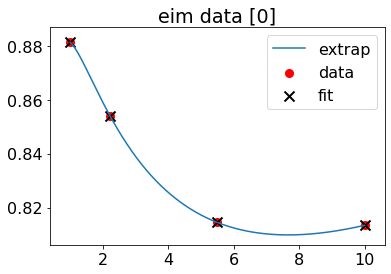

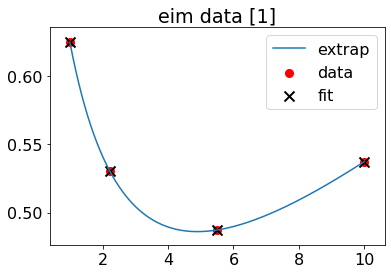

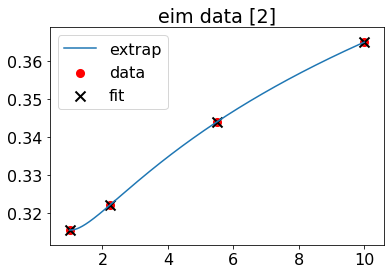

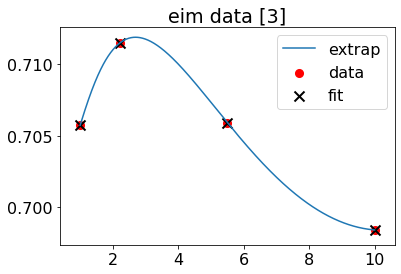

total number of greedy points = 4
worst error = 0.006833613802178941
worst case = [1.35015624]


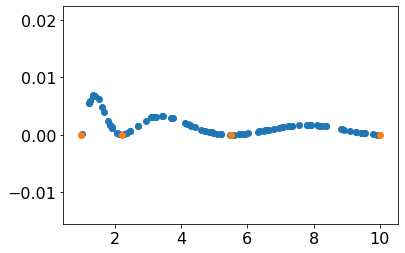

In [268]:
mtotal = 60
amp_x, amp_sur = build_surrogate_iterative(
    amp_or_phase="amp",
    qmin=1,
    qmax=10,
    qnpts=10,
    mtotal=mtotal,
    nvalidation_points=100,
    iterate_surrogate_error=False,
    max_iter=5,
    sur_model_error_tol=0.0001,
    initial_greedy_tol=1e-3,
    iterated_greedy_tol=1e-12,
    fit_method='lr'
)

In [255]:
amp_sur.grb.greedy_points

array([[ 1.        ],
       [ 5.5       ],
       [10.        ],
       [ 2.20622848],
       [ 1.30829422],
       [ 7.78045702],
       [ 3.24841434]])

In [256]:
amp_sur.grb.greedy_points.shape

(7, 1)

In [257]:
amp_sur.grb.eim.data.shape

(7, 7)

# test packaged version

In [6]:
def build_surrogate_iterative(
    amp_or_phase,
    qmin=1,
    qmax=10,
    qnpts=10,
    mtotal=100,
    nvalidation_points=100,
    iterate_surrogate_error=True,
    max_iter=5,
    sur_model_error_tol=2,
    initial_greedy_tol=1e-3,
    iterated_greedy_tol=1e-12,
    fit_method='lr'
):
    """
    qnpts: initial number of points to check seed basis
    nvalidation_points: number of points to validate the model
    
    
    iterate_surrogate_error=True
        if True then will iterate using surrogate error in a second greedy step
        if False then will set max_iter to 1 so that it doesn't iterate
    max_iter:
        max_iter for surrogate iteration greedy step
    sur_model_error_tol:
        error tolerance for 2nd greedy step
    """
    seed_x, seed_ts_amp, seed_ts_phase, seed_ts_coords = gen_1d_massratio_data(np.linspace(qmin, qmax, 3), mtotal)
    # Make integration rule

    int_range = [seed_x[0], seed_x[-1]]
    int_num = len(seed_x)

    integration = greedyrb.Riemann(int_range, num=int_num)
    x = integration.nodes  # Define x for convenience
    
#     sur = surrogate.Surrogate1D(integration)
    sur = surrogate.NewSurrogate(integration)
    
    if amp_or_phase == "amp":
        seed_ts = seed_ts_amp
    elif amp_or_phase == "phase":
        seed_ts = seed_ts_phase
        
    sur.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)
    
    # check seed basis and add points
    _, ts_amp, ts_phase, ts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, qnpts), mtotal)
    
    if amp_or_phase == "amp":
        ts = ts_amp
    elif amp_or_phase == "phase":
        ts = ts_phase
    
    if iterate_surrogate_error == False:
        # don't iterate
        max_iter = 1
    else:
        print("iterating over surrogate error")
        
    for i in range(max_iter):
        print(f"iteration = {i}")

        if i == 0:
            greedy_tol = initial_greedy_tol
            
        else:
            greedy_tol = iterated_greedy_tol
            ts = vts_worst.reshape(1,-1)
            ts_coords = vts_coords_worst.reshape(1,-1)
            
        sur.run_greedy_sweep(ts, ts_coords, verbose=True, greedy_tol=greedy_tol)

        # build eim
        # eim needs to be built from training_set at the greedy points
        _, ts_amp, ts_phase, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), mtotal)
        if amp_or_phase == "amp":
            ts = ts_amp
        elif amp_or_phase == "phase":
            ts = ts_phase 
        sur.build_eim(ts)

        # fit_eim
        
        X = sur.grb.greedy_points.copy()
        X[:,0] = np.log(X[:,0])
        y = sur.grb.eim.data
        print(X)
#         print(np.log(X[:,0]))
        print(y)
        
        print(f"X.shape = {X.shape}")
        print(f"y.shape = {y.shape}")
        
        sur.fit_eim(X, y, method=fit_method, maxdegs=[5], max_deg_total=5)

        print(f"total number of greedy points = {sur.grb.nbasis}")

        # now validate
        _, vts_amp, vts_phase, vts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, nvalidation_points), mtotal)
        if amp_or_phase == "amp":
            vts = vts_amp
        elif amp_or_phase == "phase":
            vts = vts_phase 

        model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
        worst_error = model_errors[worst_error_index]
        print(f"worst error = {worst_error}")
        print(f"worst case = {worst_case}")

        plt.figure()
        plt.scatter(vts_coords, model_errors)
        plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
        plt.show()
        plt.close()

        vts_worst = vts[worst_error_index]
        vts_coords_worst = vts_coords[worst_error_index]

        

        # on an iteration, check if we have reached the tolerance
        if worst_error <= sur_model_error_tol:
            print(f"worst error = {worst_error}")
            print(f"worst sur_model_error_tol = {sur_model_error_tol}")
            print("tolerance reached")
            print(f"total number of greedy points = {sur.grb.nbasis}")
            break
    
    return x, sur

building seed basis
iteration = 0
step = 0, error = 0.0011020314258218457
tolerance reached. exiting
[[0.        ]
 [1.70474809]
 [2.30258509]
 [0.85480475]]
[[0.88133182 0.81444889 0.81339341 0.85019949]
 [0.62491598 0.4872501  0.53734908 0.52173101]
 [0.31558816 0.34399532 0.36491445 0.32303998]
 [0.69425714 0.69521948 0.68874463 0.70010366]]
X.shape = (4, 1)
y.shape = (4, 4)


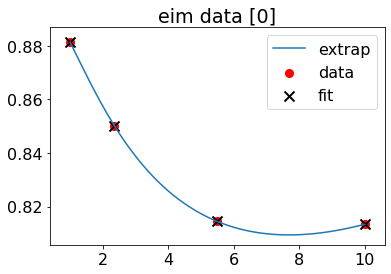

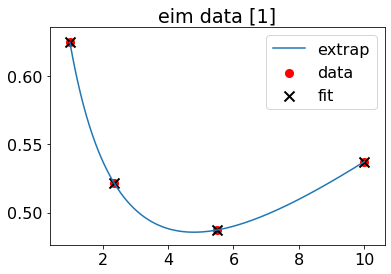

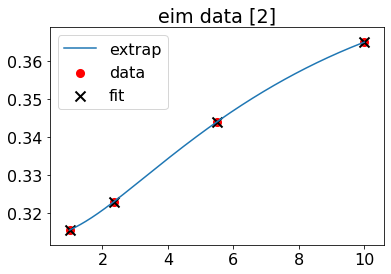

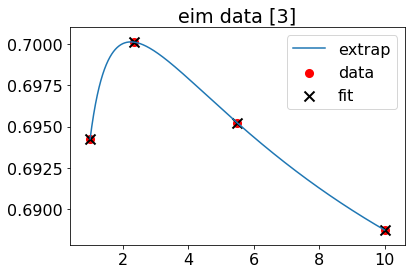

total number of greedy points = 4
worst error = 0.011230367399839606
worst case = [1.42942031]


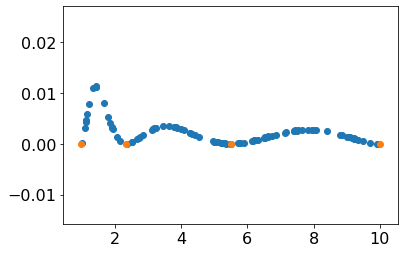

In [7]:
mtotal = 60
amp_x, amp_sur = build_surrogate_iterative(
    amp_or_phase="amp",
    qmin=1,
    qmax=10,
    qnpts=10,
    mtotal=mtotal,
    nvalidation_points=100,
    iterate_surrogate_error=False,
    max_iter=5,
    sur_model_error_tol=0.0001,
    initial_greedy_tol=1e-3,
    iterated_greedy_tol=1e-12,
    fit_method='lr'
)